In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
import ipyleaflet
from ipyleaflet import Map
from scipy import stats
from sklearn.metrics import mean_squared_log_error
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/train.csv')

## Feature engineering (básico)

Varias columnas que podrían ser interesantes como features cuentan con null values.

In [ ]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False)

In [ ]:
pd.DataFrame(df.isna().sum()).sort_values(by=0)

Inferimos la información faltante tomando la media de los valores que si están presentes en cada columna.

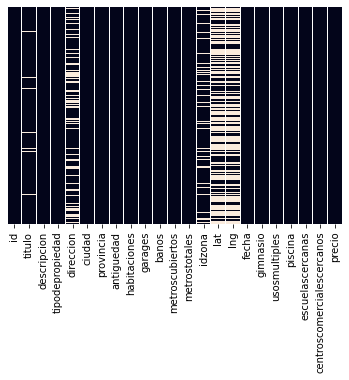

In [3]:
quantity_columns = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales']

for col in quantity_columns:
    df[col] = df[col].fillna(df[col].mean())

sns.heatmap(df.isna(), yticklabels=False, cbar=False)

## Prueba

### Función auxiliar

In [217]:
def train_and_predict(x, y, x_test, y_test, apply_x, apply_y, f):

    A = apply_x(x)
    b = apply_y(y)

    AtA = A.T @ A
    Atb = A.T @ b

    coefs = solve(AtA, Atb)

    plt.figure(figsize=(12, 12))

    # predict & plot sobre train set
    y_pred = f(x, coefs)
    eps = y - y_pred

    ax1 = plt.subplot(221)
    ax1.plot(x, y, '.')
    ax1.plot(x, y_pred, 'r')
    ax1.set_title('fit train')
    ax1.grid(True)

    ax2 = plt.subplot(222)
    ax2.plot(x, eps, '.')
    ax2.set_title('residuals train')
    ax2.grid(True)

    # predict & plot sobre test set
    y_pred = f(x_test, coefs)
    eps = y_test - y_pred

    ax3 = plt.subplot(223)
    ax3.plot(x_test, y_test, '.')
    ax3.plot(x_test, y_pred, 'r')
    ax3.set_title('fit test')
    ax3.grid(True)

    ax4 = plt.subplot(224)
    ax4.plot(x_test, eps, '.')
    ax4.set_title('residuals test')
    ax4.grid(True)

    error = mean_squared_log_error(y_test, y_pred)
    
    print(f"Error: {error}")
    print(f"Coefs: {coefs}")
    
    plt.show()
    
    return error, coefs

### Segmentación básica

In [7]:
selection_df = df[
    (df['ciudad'] == 'Querétaro') &
    (df['tipodepropiedad'] == 'Casa')
].dropna()

limit = math.floor(selection_df.shape[0] * .8)

train_df = selection_df[:limit]
test_df = selection_df[limit:]

print(f"train_df {train_df.shape}")
print(f"test_df {test_df.shape}")

train_df (1903, 23)
test_df (476, 23)


## Feature selection

En esta sección probamos dos técnicas para elegir los features con los que vamos a armar el modelo para predecir los precios.

* Por correlation matrix selection
* <s>Por forward selection</s>

### Correlation matrix feature selection

Se observa una correlación (positiva y negativa) entre:

* metrostotales
* banos
* metroscubiertos
* precio

Lo que nos dice en primera instancia que el precio podría ser explicado por los otros tres features en principio.

In [9]:
cor = abs(train_df.corr()['precio'])
cor_target = cor[cor > 0.5]
cor_target.sort_values()

metrostotales      0.556796
banos              0.561401
metroscubiertos    0.787324
precio             1.000000
Name: precio, dtype: float64

No obstante, cuando revisamos los features restantes dos a dos, obtenemos que la correlación entre ellos podría considerarse también alta, con lo que sólo una de ellas sería necesaria para explicar el precio. En este primer caso, tomamos `metroscubiertos` ya que tiene mayor correlación con `precio`.

In [10]:
print(train_df[['banos', 'metroscubiertos']].corr())

                   banos  metroscubiertos
banos            1.00000          0.64305
metroscubiertos  0.64305          1.00000


En este segundo caso, como se mencionó antes, la correlación también es alta, por lo que se optó por mantener `metroscubiertos` por la razón comentada previamente.

In [11]:
print(train_df[['metroscubiertos', 'metrostotales']].corr())

                 metroscubiertos  metrostotales
metroscubiertos         1.000000       0.574292
metrostotales           0.574292       1.000000


En conclusión, `metroscubiertos` explicaría bien el precio para la segmentación que estamos probando.

#### Comportamiento del feature respecto del target

El objetivo es inferir la relación entre, en este caso `precio` medio en función de `metroscubiertos`. Grafiquemos para tener una primera intuición:

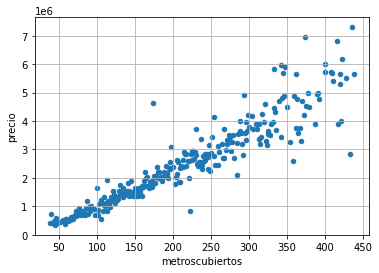

In [229]:
# ¿ *esto vs sin agrupar* ?

train_feature_df = train_df.groupby('metroscubiertos').mean().reset_index()
test_feature_df = test_df.groupby('metroscubiertos').mean().reset_index()

# removemos outliers de train set
train_feature_df = train_feature_df[(np.abs(stats.zscore(train_feature_df)) < 3).all(axis=1)]

# graficamos para hacernos una idea de la linealidad entre las dos variables
train_feature_df.plot.scatter(y='precio', x='metroscubiertos')
plt.grid(True)
plt.show()

x = train_feature_df['metroscubiertos']
y = train_feature_df['precio']

x_test = test_feature_df['metroscubiertos']
y_test = test_feature_df['precio']

Se puede ver como la varianza va incrementando poco a poco a medida que la cantidad de `metroscubiertos` aumenta. Esto podria traernos luego complicaciones para fitear esos datos ya que puede ser más dificil encontrar una función que los represente. Aplicar una transformación a los datos nos ayudaría a reducir un poco esa varianza y a hacer más certera nuestra aproximación. Aplicando $log$ sobre los dos features:

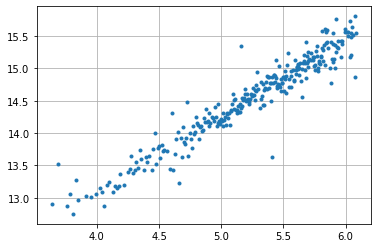

In [230]:
plt.plot(np.log(x), np.log(y), '.')
plt.grid(True)
plt.show()

Lo que ahora nos facilita plantear la siguiente regresión:

$$log(y) = \alpha_1 + \alpha_2 * log(x)$$

Observemos que en base a la misma

$$y = e^{\alpha_1 + \alpha_2 * log(x)}$$

In [231]:
def apply_x(x):
    return np.stack(evaluate(x)).T

def apply_y(y): return np.log(y)

def f(x,coef):
    result = sum([c * v for c, v in zip(coef, evaluate(x))])
    return np.e**result

Error: 0.03795474388766943
Coefs: [8.54331371 1.14682822]


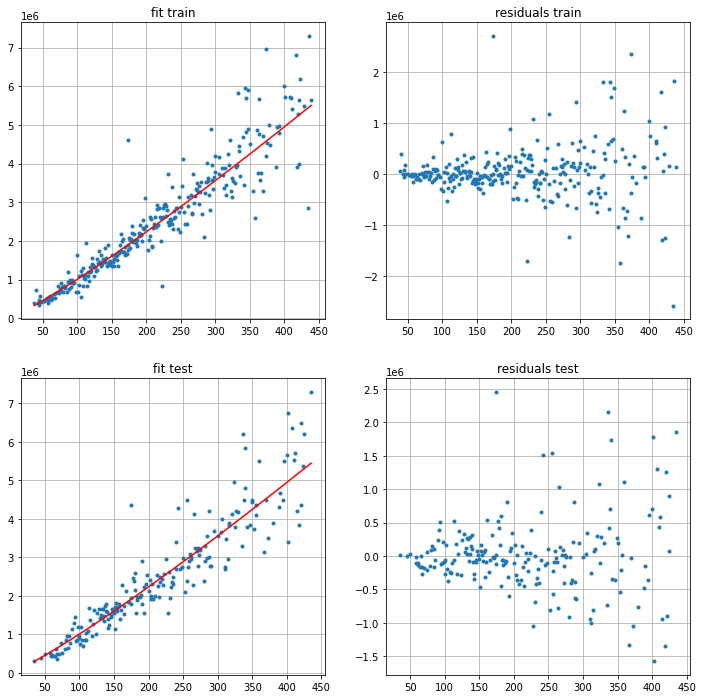

(0.03795474388766943, array([8.54331371, 1.14682822]))

In [232]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x)
    ]

train_and_predict(x, y, x_test, y_test, apply_x, apply_y, f)

Observemos que $y = x^{\alpha_2} * e^{\alpha_1}$ por la igualdad previa. Con lo que $y$ es una función lineal, la cual puede verse en los plots de fit.

Aunque hay una aproximación, y el ajuste en el test set no parece ser tan malo, se observa en los plots de residuals un claro patrón curvo hacia abajo, lo que nos indica que el error, $\epsilon$ no tiene distribución $N\sim(0, \sigma^2)$ con $\sigma^2$ constante para todos los valores de $x$. Esto nos lleva a que puede ser mejorada la aproximación.

Seguidamente, podemos intentar agregando términos polinómicos, sólo para ver que tan preponderantes son al hacer las predicciones:

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x + \alpha_4 * x^2 + \alpha_5 * x^3 + \alpha_6 * x^4 $$

Error: 0.03787750568265579
Coefs: [ 1.63072835e+01 -1.51104714e+00  6.57634751e-02 -2.66759162e-04
  5.77190227e-07 -4.83494016e-10]


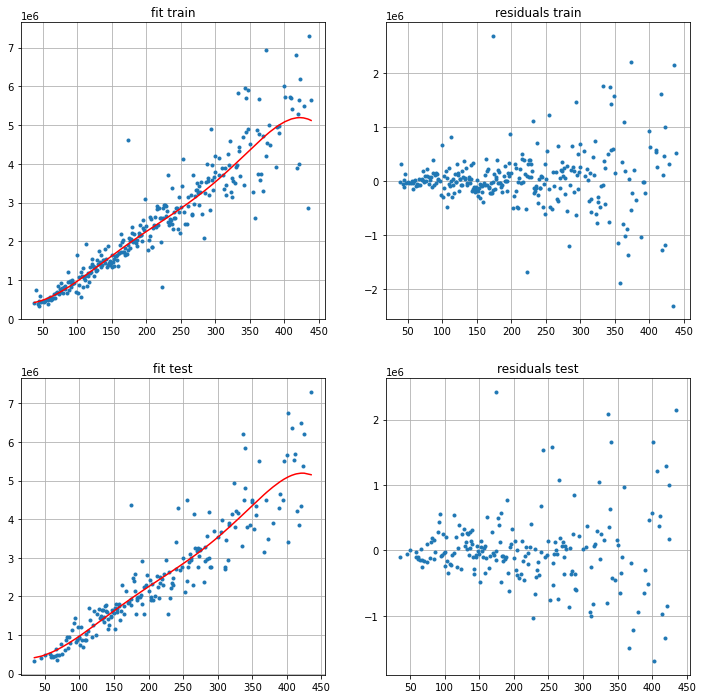

(0.03787750568265579,
 array([ 1.63072835e+01, -1.51104714e+00,  6.57634751e-02, -2.66759162e-04,
         5.77190227e-07, -4.83494016e-10]))

In [233]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x,
        x**2,
        x**3,
        x**4,
    ]

train_and_predict(x, y, x_test, y_test, apply_x, apply_y, f)

Podemos observar una mejora en el error, así como una mayor "versatilidad" del modelo frente a las variaciones en los datos si miramos el plot de fit. Si miramos el plot de residuals, podemos ver que el patrón curvo hacia abajo no es tán prominente como lo fue en el caso anterior. No obstante, la varianza aún no es constante, y esto es principalmente sobre la media de los precios de propiedades con mayor cantidad de `metroscubiertos`.

Sobre los coeficientes obtenidos, observemos que la importancia se corresponde con el grado del término polinómico agregado.

Idealmente, nos gustaría poder reducir la varianza en el error. La forma que tienen los datos de entrenamiento sugieren un patron en ciclo que sugerimos podria ser de la siguiente forma (violeta):

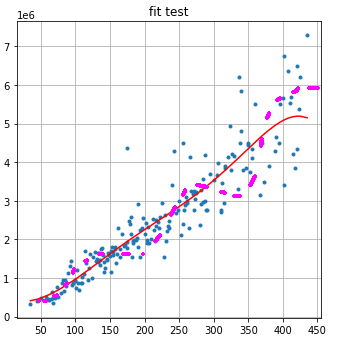

Este patrón nos permitiría frente a muestras más grandes seguir estimando bien los precios si es que los datos a predecir aumentan su varianza a medida que aumentan los metros totales.

Para ello vamos a introducir las funciones $sin$ y $cos$ a nuestra familia:

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x + \alpha_4 * x^2 + \alpha_5 * x^3 + \alpha_6 * x^4 + \alpha_7  * \phi_1(x) * sin(\frac{x}{k}) + \alpha_8 * \phi_2(x) * cos(\frac{x}{k}) $$

Error: 0.03789862804785943
Coefs: [ 1.62592583e+01 -1.49146785e+00  6.50379361e-02 -2.62706944e-04
  5.65757021e-07 -4.71501945e-10  3.12199310e-05 -4.81309618e-05]


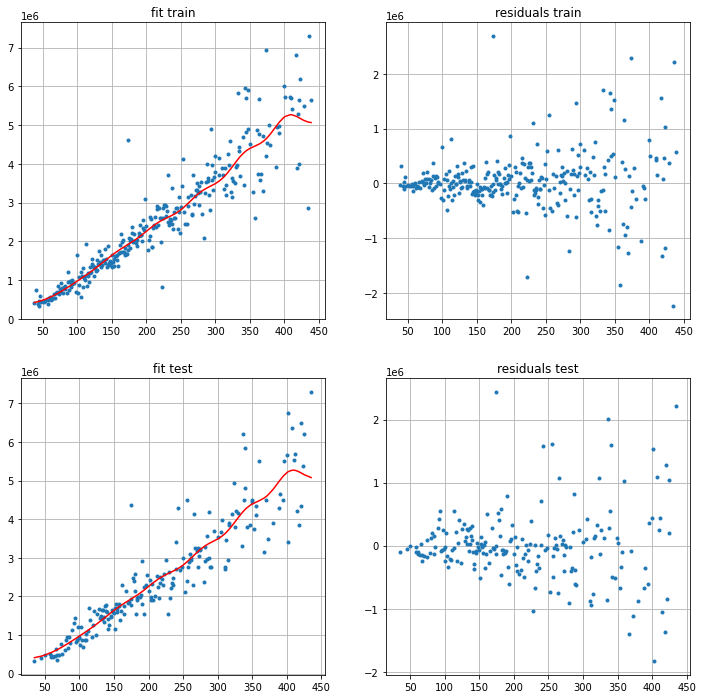

(0.03789862804785943,
 array([ 1.62592583e+01, -1.49146785e+00,  6.50379361e-02, -2.62706944e-04,
         5.65757021e-07, -4.71501945e-10,  3.12199310e-05, -4.81309618e-05]))

In [242]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x,
        x**2,
        x**3,
        x**4,
        x * np.sin(x/10),
        x * np.cos(x/10)
    ]

train_and_predict(x, y, x_test, y_test, apply_x, apply_y, f)

Si bien en el plot de residuals seguimos notando la varianza no constante, el error de la aproximación es también menor. $\phi_i$ y $k$ fueron buscados a mano de forma tal que la frecuencia y la amplitud de la onda creada se viera afectada positivamente (sea más parecida a la de la propuesta). Podría hacerse un experimento sobre esto basado en grid search para buscar mejores combinaciones.

Para dejar nuestra prueba un poco más completa, veamos que cambios hay si introducimos la función $x^\frac{1}{2}$:

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x + \alpha_4 * x^2 + \alpha_5 * x^3 + \alpha_6 * x^4 + \alpha_7  * \phi_1(x) * sin(\frac{x}{k}) + \alpha_8 * \phi_2(x) * cos(\frac{x}{k}) + \alpha_9 * \phi_3(x) * x^\frac{1}{2} $$

Error: 0.03783816364904024
Coefs: [ 2.49399626e+01 -5.09174973e+00  2.32123875e-01 -2.54949577e-03
 -4.94150518e-06  1.22152513e-09 -6.36658420e-08  2.08691958e-07
  1.94076892e-04]


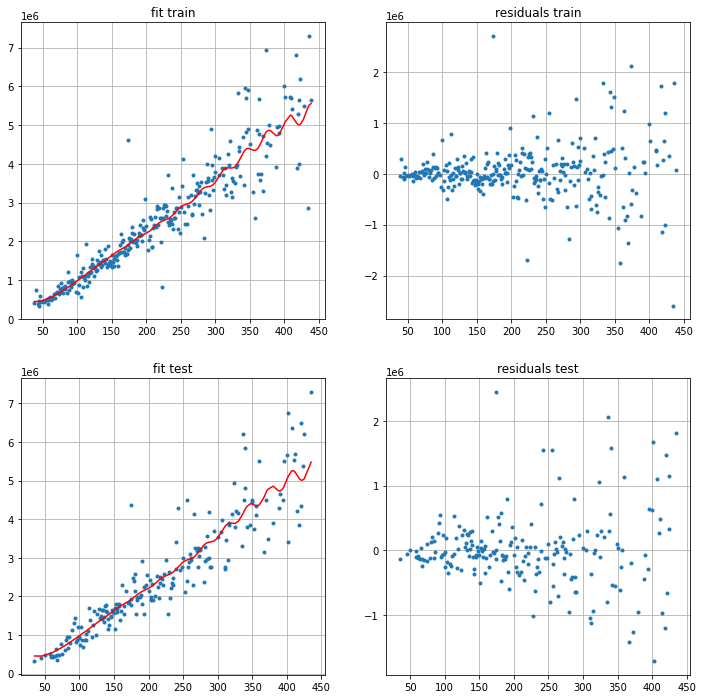

(0.03783816364904024,
 array([ 2.49399626e+01, -5.09174973e+00,  2.32123875e-01, -2.54949577e-03,
        -4.94150518e-06,  1.22152513e-09, -6.36658420e-08,  2.08691958e-07,
         1.94076892e-04]))

In [247]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x,
        x**2,
        x**3,
        x**4,
        x**2 * np.sin(x/5),
        x**2 * np.cos(x/5),
        x**2 * np.sqrt(x)
    ]

train_and_predict(x, y, x_test, y_test, apply_x, apply_y, f)

Efectivamente, podemos ver una mejora en el error, aúnque hay espacio para seguir mejorando nuestro modelo si nos basamos en el plot de fit, que sigue mostrando una varianza no constante para el error.

Si estamos conformes con los resultados obtenidos, podemos probar este modelo sobre las casas de otra ciudad, para ver su performance. Veamos sobre Guadalajara.

Error: 0.1339739757138093


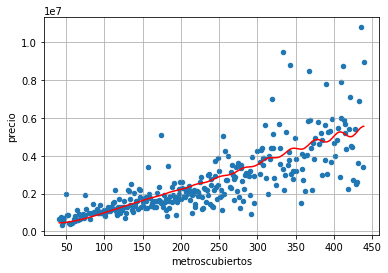

In [248]:
selection_df = df[
    (df['ciudad'] == 'Guadalajara') &
    (df['tipodepropiedad'] == 'Casa')
].dropna()

selection_df = selection_df.groupby('metroscubiertos').mean().reset_index()

# graficamos para hacernos una idea de la linealidad entre las dos variables
selection_df.plot.scatter(y='precio', x='metroscubiertos')

x = selection_df['metroscubiertos']
y = selection_df['precio']

coefs = [ 2.49399626e+01, -5.09174973e+00,  2.32123875e-01, -2.54949577e-03,
        -4.94150518e-06,  1.22152513e-09, -6.36658420e-08,  2.08691958e-07,
         1.94076892e-04]

y_pred = f(x, coefs)

print(f"Error: {mean_squared_log_error(y, y_pred)}")

plt.plot(x, y, '.')
plt.plot(x, y_pred, 'r', color='red')
plt.grid(True)
plt.show()

Aunque a juzgar por el gráfico parecen ser razonables las predicciones, el error más del doble en comparación al obtenido previamente, lo que nos lleva a pensar que tal vez el modelo no generalice bien. Entre otras cosas, esto puede ocurrir:

* por falta de algún feature que necesitemos
* por falta de más familias que puedan explicar los datos
